In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 

g = torch.Generator().manual_seed(2147483647)
# reads in all the words
words = open("names.txt", 'r').read().splitlines()

# building encoder
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

# set parameters
n_hidden = 200
n_embd = 10
numb_tests = 20000
block_size = 10 # context, number of characters taken in to predict the next
vocab_size = len(itos)

In [12]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True): # fan_in = n_embedding * block_size
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kaiming initialization, normalizes the samples
        self.bias = torch.zeros(fan_out) if bias else None # initializes biases to zero
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# makes everything much more robust, not effected significantly from large changes in normalization of the samples or changes in learning rates


In [13]:

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # Whether its training or evaluating
        # parameters *(trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculates the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    


In [14]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [15]:

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# last layer: make less confident
layers[-1].gamma *= 0.1
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 1.0 # messing with this will effect the ratio of data change in graph 3, the saturation will apporoach 0.00 while std shrinks
                            # The linear layers preserve std, but the Tanh layers will squeeze the function within a range, this
                            # value is to counteract the squeezing so std won't shrink, making this too high would make saturation too high
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True

TypeError: ones() received an invalid combination of arguments - got (int, int, generator=torch._C.Generator), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padding with [0] = '.'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
 # training split, dev/validation split, test split
 # 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
batch_size = 32
lossi = []
ud = [] # update to data ratio for plotting

for i in range(numb_tests):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{numb_tests:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # update ratios 



      0/  20000: 3.2958
  10000/  20000: 2.7882


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

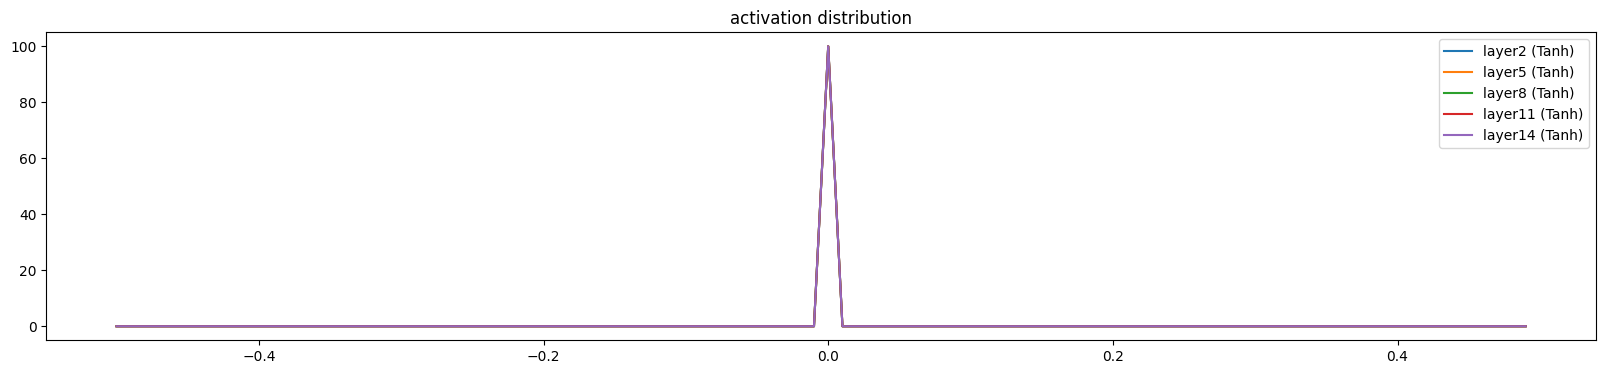

In [ ]:
# histagram of 4 past iterations
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh): # looking at Tanh layers because they have finite range => easier visualization
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) # y and x of probability density function of t
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

# check to see if saturation is too high. If saturation is too high, then we forgot the normalization after sampling from gaussian
# forward pass

layer 2 (      Tanh): mean +0.00, std 0.000000e+00
layer 5 (      Tanh): mean +0.00, std 0.000000e+00
layer 8 (      Tanh): mean +0.00, std 0.000000e+00
layer 11 (      Tanh): mean +0.00, std 0.000000e+00
layer 14 (      Tanh): mean +0.00, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

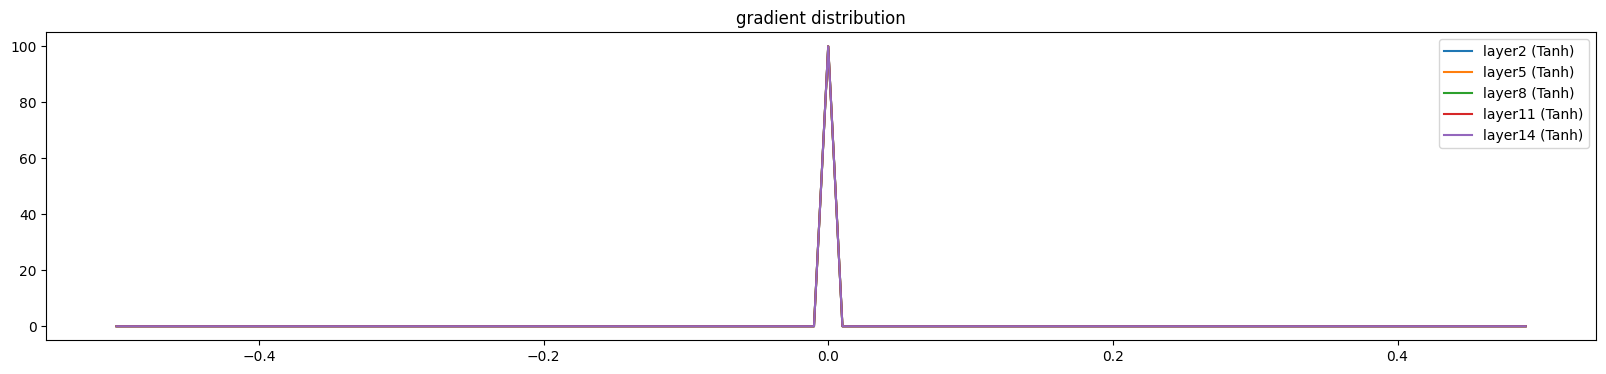

In [ ]:
# histagram of 4 past iterations
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

# check to see if they all have roughly the same gradient 
# backward pass

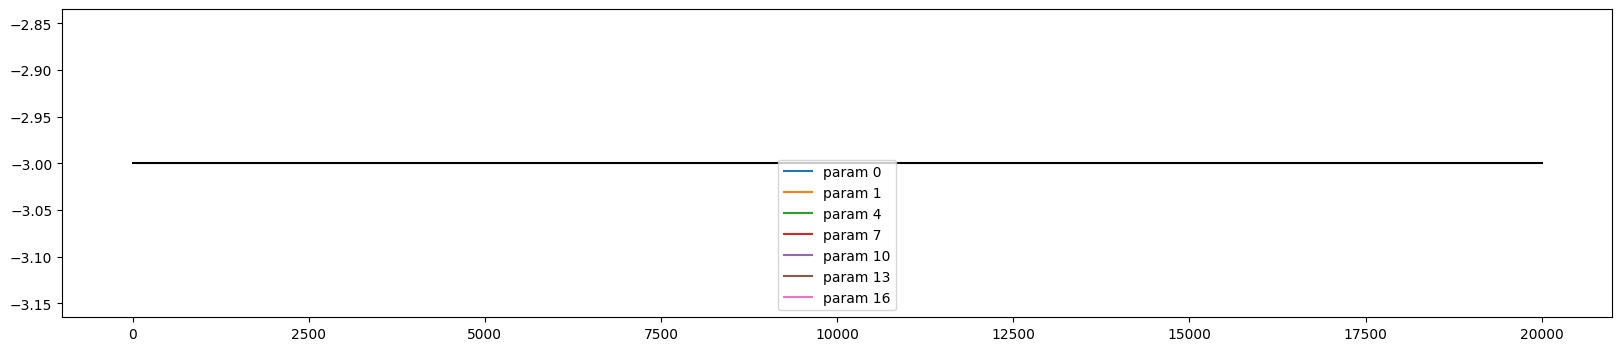

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # should be around 1e-3, aka -3 on y, if learning rate is too low, this graph will be horizontal lines
plt.legend(legends)
# update to data ratio

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight (100, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (200, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


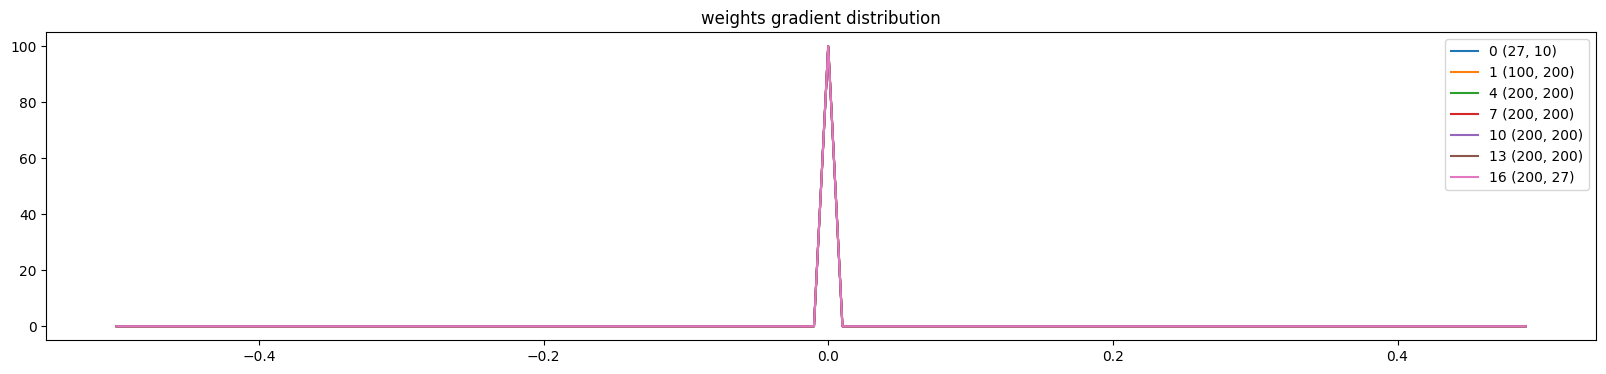

In [ ]:
# visualize gradient to data ratio
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
# want the grad to data ratio to be small


In [ ]:
for _ in range(10):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(emb.shape[0], -1)
        for layer in layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
            embcat = layer(embcat)
        logits = embcat
        probs = F.softmax(logits, dim=1)
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

a.
lsl.
ieia.
krkaanmt.
ozna.
rlttl.
.
nat.
avaieaak.
ala.
